In [1]:
from six.moves import xrange
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from model import VQVAE, _imagenet_arch, PixelCNN

DATA_DIR = 'datasets/ILSVRC2012'
MODEL,K,D = \
    ('models/imagenet/last.ckpt',
     512,
     128)
PIXELCNN_MODEL,NUM_LAYERS,NUM_FEATURE_MAPS = \
    ('models/imagenet/last-pixelcnn.ckpt',
     18,
     256)

import sys
sys.path.append('slim_models/research/slim')
from datasets import imagenet
slim = tf.contrib.slim

train_dataset = imagenet.get_split('train','datasets/ILSVRC2012')
valid_dataset = imagenet.get_split('validation','datasets/ILSVRC2012')
def _build_batch(dataset,batch_size,num_threads):
    with tf.device('/cpu'):
        provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset,
            num_readers=num_threads,
            common_queue_capacity=20*batch_size,
            common_queue_min=10*batch_size,
            shuffle=True)
        image,label = provider.get(['image','label'])
        pp_image = tf.image.resize_images(image,[128,128]) / 255.0

        images,labels = tf.train.batch(
            [pp_image,label],
            batch_size=batch_size,
            num_threads=num_threads,
            capacity=5*batch_size)
        return images, labels
train_ims,train_labels = _build_batch(train_dataset,16,4)
valid_ims,valid_labels = _build_batch(valid_dataset,16,1)
# <<<<<<<

# >>>>>>> MODEL
with tf.variable_scope('net'):
    with tf.variable_scope('params') as params:
        pass
    x = tf.placeholder(tf.float32,[None,128,128,3])
    net = VQVAE(None,None,0.25,x,K,D,_imagenet_arch,params,False)
    
with tf.variable_scope('pixelcnn'):
    pixelcnn_net = PixelCNN(None,None,None,
                   net.k.get_shape()[1],net.embeds,K,D,
                   1000,NUM_LAYERS,NUM_FEATURE_MAPS,False)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.graph.finalize()
sess.run(init_op)
net.load(sess,MODEL)
pixelcnn_net.load(sess,PIXELCNN_MODEL)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


INFO:tensorflow:Restoring parameters from models/imagenet/last.ckpt
INFO:tensorflow:Restoring parameters from models/imagenet/last-pixelcnn.ckpt


## ImageNet Label and Names

In [2]:
for i, name in train_dataset.labels_to_names.items():
    print(i,name)

0 background
1 tench, Tinca tinca
2 goldfish, Carassius auratus
3 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
4 tiger shark, Galeocerdo cuvieri
5 hammerhead, hammerhead shark
6 electric ray, crampfish, numbfish, torpedo
7 stingray
8 cock
9 hen
10 ostrich, Struthio camelus
11 brambling, Fringilla montifringilla
12 goldfinch, Carduelis carduelis
13 house finch, linnet, Carpodacus mexicanus
14 junco, snowbird
15 indigo bunting, indigo finch, indigo bird, Passerina cyanea
16 robin, American robin, Turdus migratorius
17 bulbul
18 jay
19 magpie
20 chickadee
21 water ouzel, dipper
22 kite
23 bald eagle, American eagle, Haliaeetus leucocephalus
24 vulture
25 great grey owl, great gray owl, Strix nebulosa
26 European fire salamander, Salamandra salamandra
27 common newt, Triturus vulgaris
28 eft
29 spotted salamander, Ambystoma maculatum
30 axolotl, mud puppy, Ambystoma mexicanum
31 bullfrog, Rana catesbeiana
32 tree frog, tree-frog
33 tailed frog, bell t

468 butcher shop, meat market
469 cab, hack, taxi, taxicab
470 caldron, cauldron
471 candle, taper, wax light
472 cannon
473 canoe
474 can opener, tin opener
475 cardigan
476 car mirror
477 carousel, carrousel, merry-go-round, roundabout, whirligig
478 carpenter's kit, tool kit
479 carton
480 car wheel
481 cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM
482 cassette
483 cassette player
484 castle
485 catamaran
486 CD player
487 cello, violoncello
488 cellular telephone, cellular phone, cellphone, cell, mobile phone
489 chain
490 chainlink fence
491 chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour
492 chain saw, chainsaw
493 chest
494 chiffonier, commode
495 chime, bell, gong
496 china cabinet, china closet
497 Christmas stocking
498 church, church building
499 cinema, movie theater, movie theatre, movie house, picture palace
500 cleaver, meat cleaver, chopper
501 cliff dwelling
502 

## ImageNet Reconstruction - Validation Set

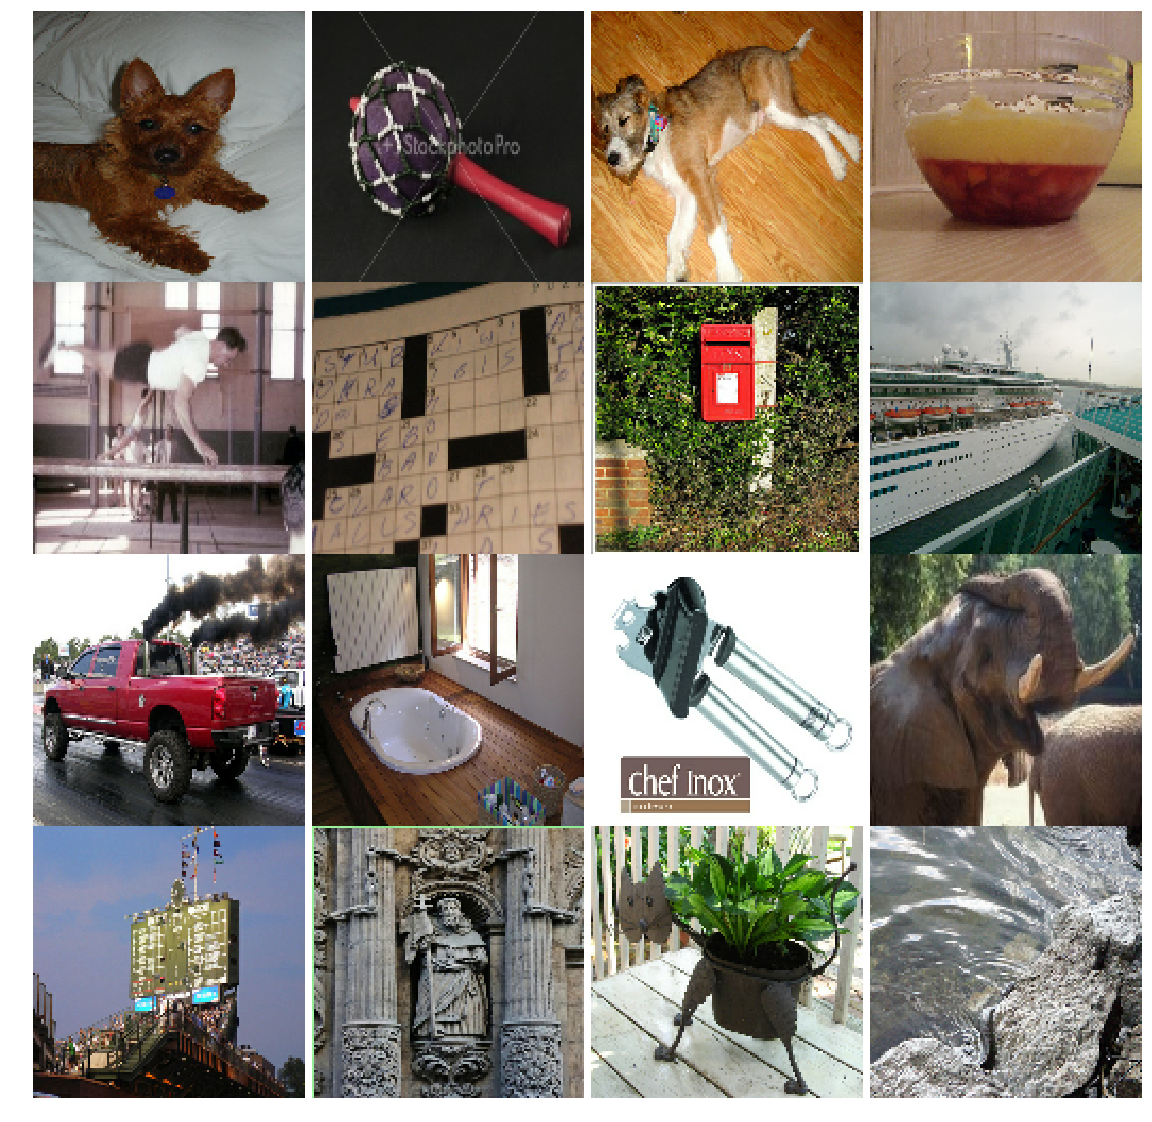

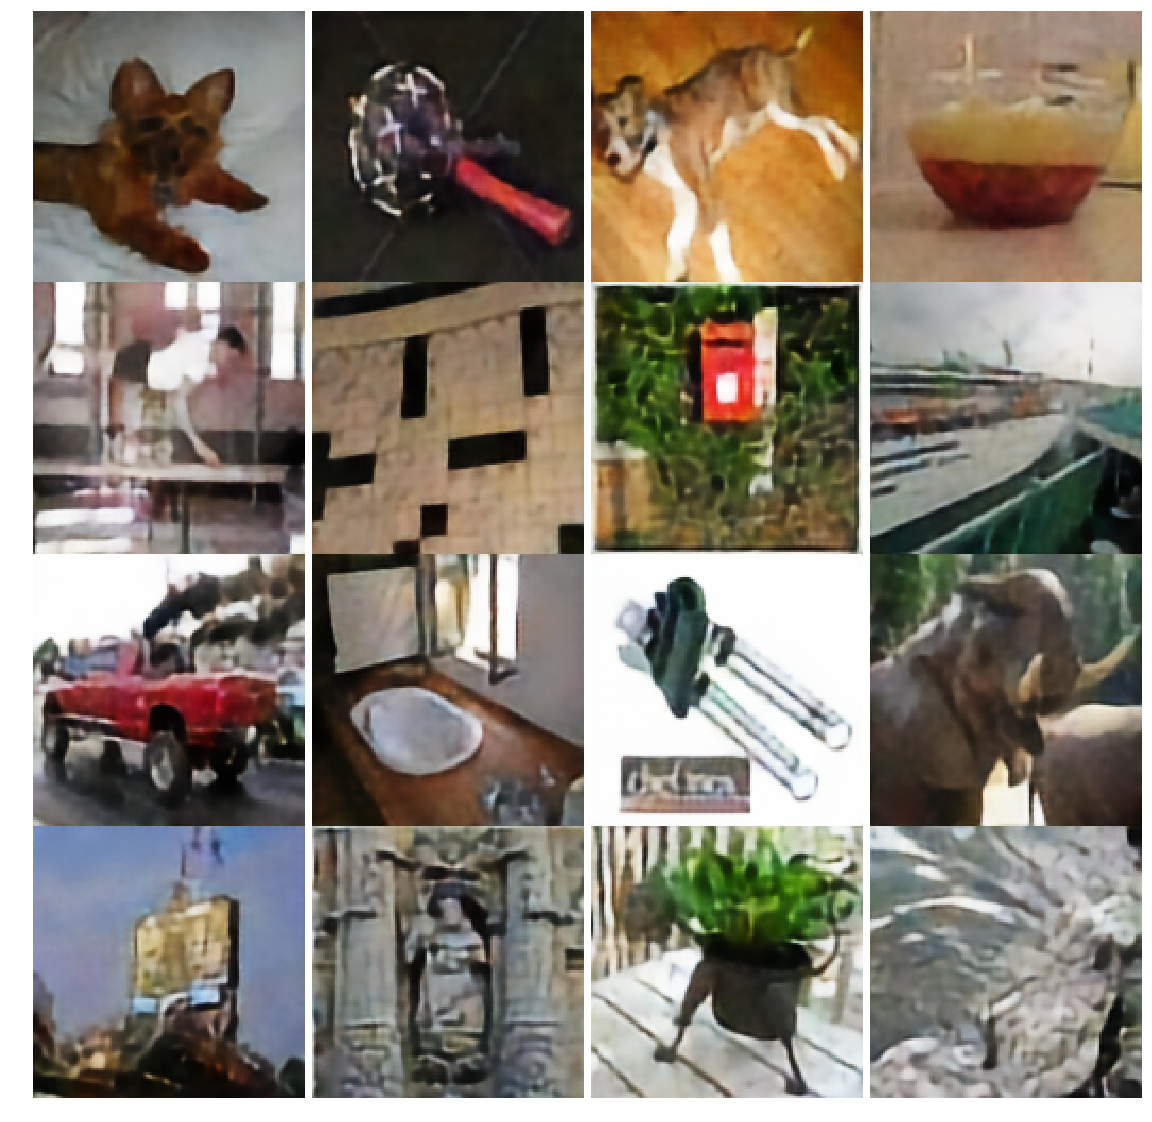

In [3]:
def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(20,20))
    for n, image in enumerate(images):
        a = fig.add_subplot(4, 4, n + 1)
        a.imshow( (image*255.0).astype(np.uint8) )
        a.axis('off')
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

valid_origin = sess.run(valid_ims)
valid_recons = sess.run(net.p_x_z,feed_dict={x:valid_origin})
draw(valid_origin)
draw(valid_recons)

## Sampled Cifar10 (Class Conditioned)

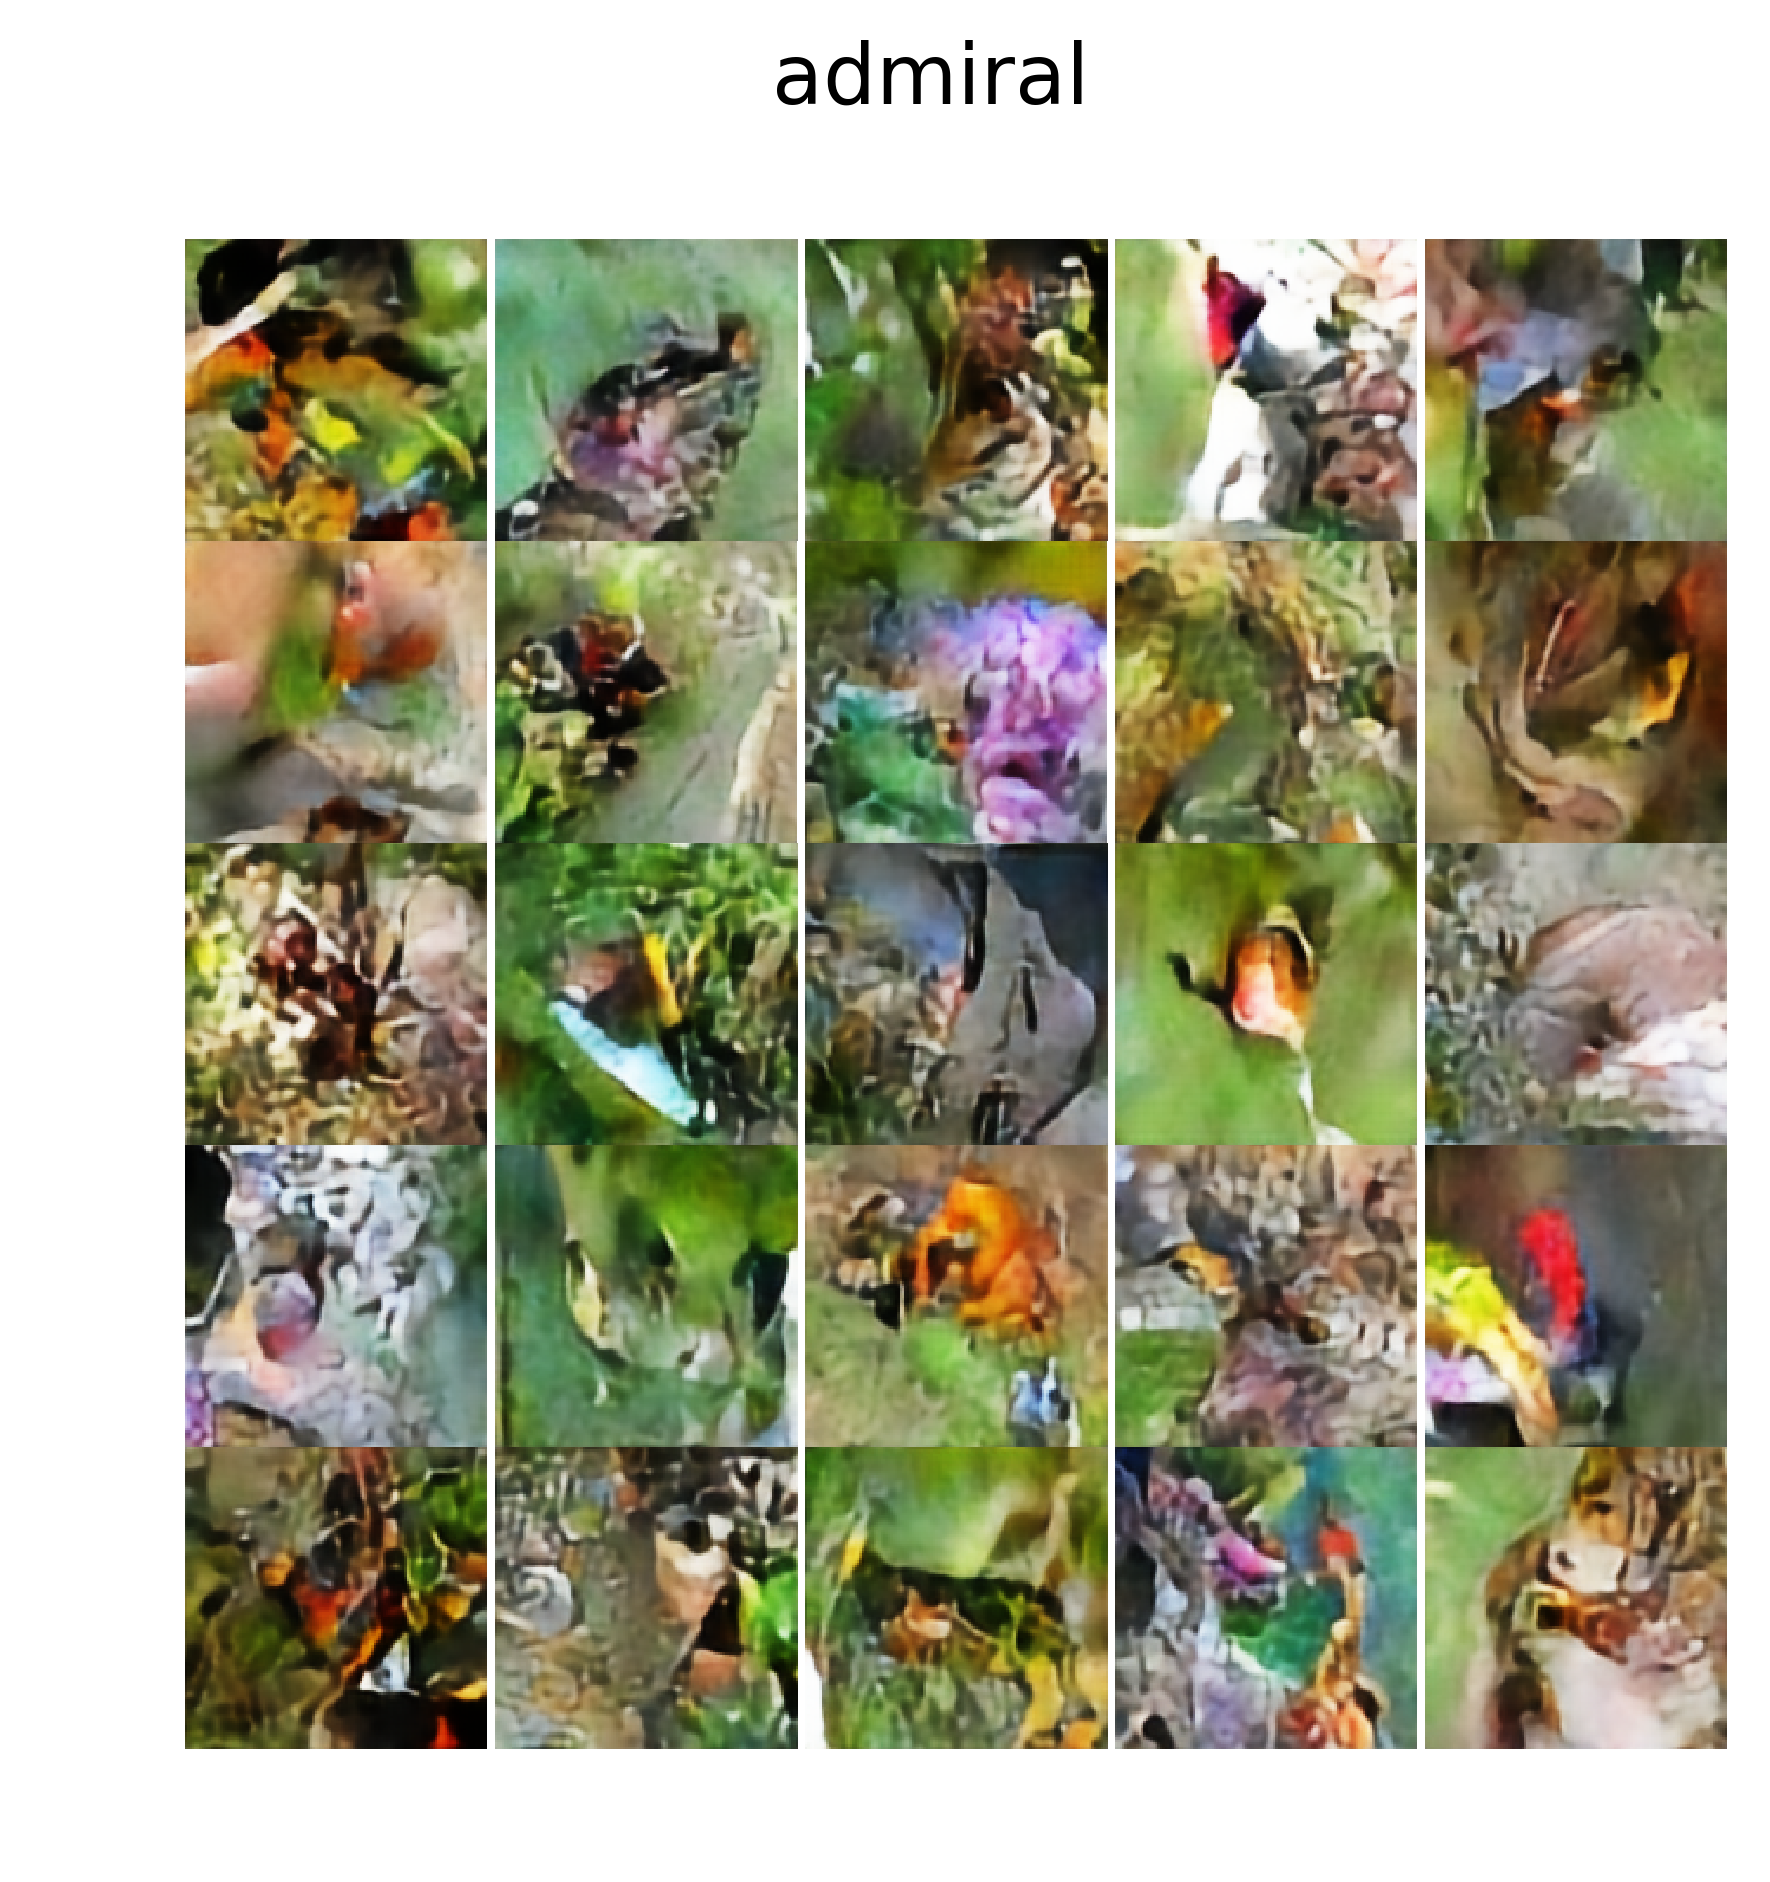

In [26]:
def draw(images,name):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(5,5),dpi=400)
    for n, image in enumerate(images):
        a = fig.add_subplot(5, 5, n + 1)
        a.imshow( np.squeeze((image*255.0)).astype(np.uint8) )
        a.axis('off')
        a.set_aspect('equal')
    plt.suptitle(name.split(',')[0], fontsize=15)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

IDX = 322 #CORAL REEF(974), Alp(971), Gray Whale(148), Pick Up(718), BrownBear(295), Admiral(322)
sampled_zs,log_probs = pixelcnn_net.sample_from_prior(sess,[IDX]*5,5)
sampled_ims = sess.run(net.gen,feed_dict={net.latent:sampled_zs})
draw(sampled_ims, train_dataset.labels_to_names[IDX] )